In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import os, re

In [2]:
from scripts.utils import dictEndpoint
from scripts.utilsMetric import metrics as dictMetrics

In [3]:
dataDir = "data"
data = {endpoint: pd.read_csv(f"{dataDir}/{endpoint}_dataset.csv")
        for endpoint in dictEndpoint
}
Y = {k:v["Label"] for k,v in data.items() }

In [4]:
idxDir = "intraDomainIdxs"
idxs = { endpoint : np.loadtxt(f"{idxDir}/{endpoint}_idxs.txt", dtype=int)
             for endpoint in dictEndpoint }

In [5]:
Yfilt = {k:v[ idxs[k] ] for k,v in Y.items()}

In [58]:
def calcResultsCV(name, dir, compiler):
    path = f"{dir}/{name}"
    info = compiler.search(name).groupdict()
    labels = Yfilt[info["endpoint"]].values
    scoresDF = pd.read_csv(path)
    df = pd.DataFrame()
    
    for _,cv in scoresDF.items():
        maskScores = cv.notna()
        
        # -1 are scores referred to non decision, so they are not converted in binary label
        maskBinary = cv>=0
        
        yBinary = labels[maskBinary]
        yScores = labels[maskScores]

        preds = cv.copy()[maskBinary].apply(lambda x: 1 if x>=.5 else 0)
        # -1 scores are converted in undecision score = 0.5
        scores = cv.copy()[maskScores].apply(lambda x: 0.5 if x==-1 else x)
        
        results = {metric:fnc(yBinary, preds, scores) for metric,fnc in dictMetrics.items() if metric!="ROCcurve"}
        results ["ROCcurve"] = dictMetrics["ROCcurve"](yScores, preds, scores)
        
        df = pd.concat([df,
                        pd.DataFrame([results])
                       ], ignore_index=True)

    df = df.assign(**info)
    return df

# KNN CV

In [27]:
dirKNN = "scoresCV_KNN/"

In [28]:
scoresKNN = [file for file in os.listdir(dirKNN) if "scores" in file ]

In [29]:
compilerKNN = re.compile(
'(?P<endpoint>[a-z]+)_thr(?P<thr>[0-9]?\.{1}[0-9]+)_?cv(?P<cv>[0-9]+)_?test(?P<test>[0-9]?\.{1}[0-9]+)'
)

In [45]:
resultsKNN = pd.concat([
    calcResultsCV(file, dir=dirKNN, compiler=compilerKNN) for file in scoresKNN
])

In [46]:
resultsKNN=resultsKNN.groupby(list(compilerKNN.groupindex.keys())).describe()

In [47]:
resultsKNN.loc[:,(slice(None), ["mean","std"])]

Accuracy           Sensitivity           Specificity  \
                           mean       std        mean       std        mean   
endpoint thr  cv test                                                         
andro    0.44 30 0.1   0.668106  0.095694    0.426787  0.171210    0.909426   
carcino  0.36 30 0.1   0.691232  0.111479    0.626891  0.148038    0.755574   
chrom    0.37 30 0.1   0.605013  0.173192    0.559257  0.248436    0.650770   
devtox   0.54 30 0.1   0.678812  0.176830    0.903815  0.071734    0.453810   
estro    0.45 30 0.1   0.638353  0.157342    0.313532  0.309265    0.963173   
hepa     0.62 30 0.1   0.577496  0.157019    0.590468  0.214985    0.564524   
muta     0.39 30 0.1   0.695840  0.161452    0.757998  0.132248    0.633683   
skin     0.44 30 0.1   0.557771  0.240340    0.403492  0.375526    0.712050   

                                       f1            ROCcurve            
                            std      mean       std      mean       std  
endpoint thr  cv test                                                    
andro    0.44 30 0.1   0.047451  0.429363  0.166751  0.645537  0.083585  
carcino  0.36 30 0.1   0.100349  0.616492  0.140230  0.653608  0.077880  
chrom    0.37 30 0.1   0.168301  0.556544  0.241495  0.581481  0.102804  
devtox   0.54 30 0.1   0.340045  0.891169  0.066155  0.624852  0.143225  
estro    0.45 30 0.1   0.020610  0.319940  0.297734  0.623600  0.135821  
hepa     0.62 30 0.1   0.168662  0.577313  0.188618  0.560806  0.097169  
muta     0.39 30 0.1   0.231551  0.746243  0.132783  0.633906  0.084697  
skin     0.44 30 0.1   0.218576  0.409356  0.374039  0.561068  0.137057

In [54]:
resultsKNN.loc[:,(slice(None), ["mean","std"])].describe()

Accuracy           Sensitivity           Specificity            \
           mean       std        mean       std        mean       std   
count  8.000000  8.000000    8.000000  8.000000    8.000000  8.000000   
mean   0.639078  0.159168    0.572780  0.208930    0.705376  0.161943   
std    0.053355  0.043775    0.194384  0.099464    0.169835  0.104701   
min    0.557771  0.095694    0.313532  0.071734    0.453810  0.020610   
25%    0.598134  0.145634    0.420963  0.144091    0.616393  0.087125   
50%    0.653230  0.159397    0.574863  0.193098    0.681410  0.168482   
75%    0.681917  0.174102    0.659668  0.263643    0.794037  0.221820   
max    0.695840  0.240340    0.903815  0.375526    0.963173  0.340045   

             f1            ROCcurve            
           mean       std      mean       std  
count  8.000000  8.000000  8.000000  8.000000  
mean   0.568303  0.200976  0.610607  0.107780  
std    0.186968  0.099136  0.037352  0.026858  
min    0.319940  0.066155  0.560806  0.077880  
25%    0.424362  0.138368  0.576378  0.084419  
50%    0.566928  0.177685  0.624226  0.099987  
75%    0.648930  0.255555  0.636814  0.136130  
max    0.891169  0.374039  0.653608  0.143225

# GCNN CV

In [35]:
dirGCN = "scoresCV"

In [36]:
scoresGCN = [file for file in os.listdir(dirGCN) if "scores" in file ]

In [37]:
compilerGCN = re.compile(
'(?P<endpoint>[a-z]+)_thr(?P<thr>[0-9]?\.{1}[0-9]+)_?hu(?P<hu>[0-9]+)_?es(?P<es>[0-9]+)_?\
epoch(?P<epoch>[0-9]+)_?cv(?P<cv>[0-9]+)_?test(?P<test>[0-9]?\.{1}[0-9]+)'
)

In [ ]:
resultsGCN = pd.concat([
    calcResultsCV(file, dir=dirGCN, compiler=compilerGCN) for file in scoresGCN
])

In [52]:
resultsGCN=resultsGCN.groupby(list(compilerGCN.groupindex.keys())).describe()

In [53]:
resultsGCN.loc[:,(slice(None), ["mean","std"])]

Accuracy           Sensitivity            \
                                       mean       std        mean       std   
endpoint thr  hu es epoch cv test                                             
andro    0.44 10 2  1000  30 0.1   0.736835  0.056416    0.526160  0.112636   
carcino  0.36 10 2  1000  30 0.1   0.774167  0.061764    0.721333  0.101914   
chrom    0.37 10 2  1000  30 0.1   0.632134  0.080433    0.597167  0.118630   
devtox   0.54 10 2  1000  30 0.1   0.697194  0.099671    0.933523  0.033107   
estro    0.45 10 2  1000  30 0.1   0.791808  0.096618    0.612395  0.190419   
hepa     0.62 10 2  1000  30 0.1   0.620822  0.064190    0.622013  0.100530   
muta     0.39 10 2  1000  30 0.1   0.704870  0.045826    0.705281  0.078920   
skin     0.44 10 2  1000  30 0.1   0.612791  0.107305    0.477154  0.178075   

                                  Specificity                  f1            \
                                         mean       std      mean       std   
endpoint thr  hu es epoch cv test                                             
andro    0.44 10 2  1000  30 0.1     0.947511  0.016632  0.543960  0.084177   
carcino  0.36 10 2  1000  30 0.1     0.827001  0.064839  0.709366  0.087920   
chrom    0.37 10 2  1000  30 0.1     0.667101  0.107732  0.597733  0.089420   
devtox   0.54 10 2  1000  30 0.1     0.460864  0.191166  0.919104  0.026916   
estro    0.45 10 2  1000  30 0.1     0.971221  0.016616  0.589655  0.173753   
hepa     0.62 10 2  1000  30 0.1     0.619632  0.092671  0.628055  0.083655   
muta     0.39 10 2  1000  30 0.1     0.704460  0.079765  0.707091  0.053593   
skin     0.44 10 2  1000  30 0.1     0.748428  0.117331  0.457343  0.155257   

                                   ROCcurve            
                                       mean       std  
endpoint thr  hu es epoch cv test                      
andro    0.44 10 2  1000  30 0.1   0.814496  0.049312  
carcino  0.36 10 2  1000  30 0.1   0.807781  0.059495  
chrom    0.37 10 2  1000  30 0.1   0.640387  0.092014  
devtox   0.54 10 2  1000  30 0.1   0.704454  0.112719  
estro    0.45 10 2  1000  30 0.1   0.831307  0.084290  
hepa     0.62 10 2  1000  30 0.1   0.636216  0.082266  
muta     0.39 10 2  1000  30 0.1   0.731970  0.059333  
skin     0.44 10 2  1000  30 0.1   0.646710  0.118678

In [55]:
resultsGCN.loc[:,(slice(None), ["mean","std"])].describe()

Accuracy           Sensitivity           Specificity            \
           mean       std        mean       std        mean       std   
count  8.000000  8.000000    8.000000  8.000000    8.000000  8.000000   
mean   0.696328  0.076528    0.649378  0.114279    0.743277  0.085844   
std    0.069375  0.022738    0.140777  0.050808    0.170319  0.056909   
min    0.612791  0.045826    0.477154  0.033107    0.460864  0.016616   
25%    0.629306  0.060427    0.579415  0.095127    0.655233  0.052787   
50%    0.701032  0.072312    0.617204  0.107275    0.726444  0.086218   
75%    0.746168  0.097381    0.709294  0.133491    0.857128  0.110132   
max    0.791808  0.107305    0.933523  0.190419    0.971221  0.191166   

             f1            ROCcurve            
           mean       std      mean       std  
count  8.000000  8.000000  8.000000  8.000000  
mean   0.644038  0.094336  0.726665  0.082263  
std    0.138426  0.048560  0.082621  0.025306  
min    0.457343  0.026916  0.636216  0.049312  
25%    0.578231  0.076139  0.645129  0.059454  
50%    0.612894  0.086049  0.718212  0.083278  
75%    0.707660  0.105879  0.809460  0.097191  
max    0.919104  0.173753  0.831307  0.118678

## Losses

In [20]:
PATHLS = "lossesCV"

In [21]:
allLosses = os.listdir(PATHLS)

In [22]:
allLosses

['devtox_thr0.54_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'carcino_thr0.36_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'muta_thr0.39_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'skin_thr0.44_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'andro_thr0.44_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'estro_thr0.45_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'chrom_thr0.37_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv',
 'hepa_thr0.62_hu10_es2_epoch1000_cv30_test0.1_seed0_losses.csv']

In [23]:
l = pd.read_csv(PATHLS+"/"+allLosses[-3], index_col=0, header=None)

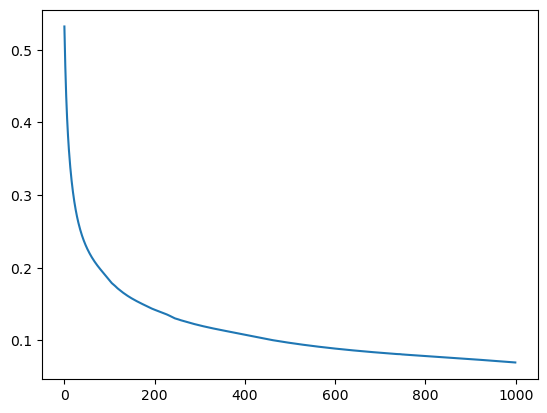

In [24]:
plt.plot(l[1])

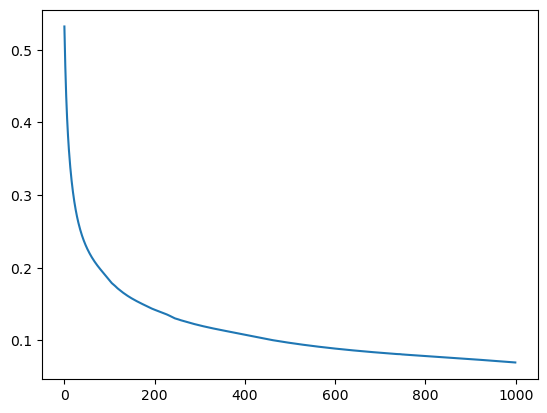

In [25]:
# Skin
plt.plot(l[1])

## Embeddings

In [26]:
PATHE="embeddingsCV/"

In [27]:
allEmbs = os.listdir(PATHE)

In [28]:
allEmbs

['devtox_thr0.54_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'carcino_thr0.36_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'muta_thr0.39_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'skin_thr0.44_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'andro_thr0.44_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'estro_thr0.45_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'chrom_thr0.37_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv',
 'hepa_thr0.62_hu10_es2_epoch1000_cv30_test0.1_seed0_embedding.csv']

In [29]:
e = pd.read_csv(PATHE+"/"+allEmbs[-3])

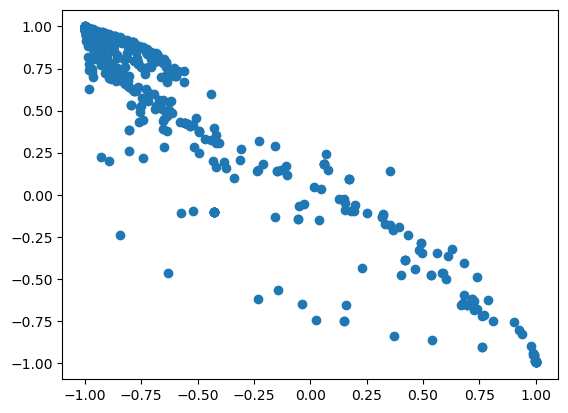

In [30]:
plt.scatter(e["0_cv9"], e["1_cv9"])